<a href="https://colab.research.google.com/github/brilliantfriezka/Machine-Learning/blob/main/Week8/Learn_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Learn SVM**

*   Nama  : Brilliant Friezka Aina
*   NIM : 1103194186


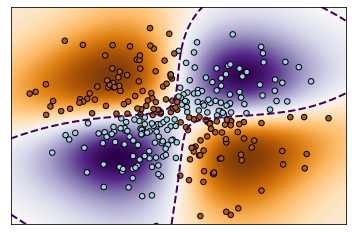

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

xx, yy = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3, 3, 500))
np.random.seed(0)
X = np.random.randn(300, 2)
Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

clf = svm.NuSVC(gamma="auto")
clf.fit(X, Y)

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    aspect="auto",
    origin="lower",
    cmap=plt.cm.PuOr_r,
)
contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2, linestyles="dashed")
plt.scatter(X[:, 0], X[:, 1], s=30, c=Y, cmap=plt.cm.Paired, edgecolors="k")
plt.xticks(())
plt.yticks(())
plt.axis([-3, 3, -3, 3])
plt.show()

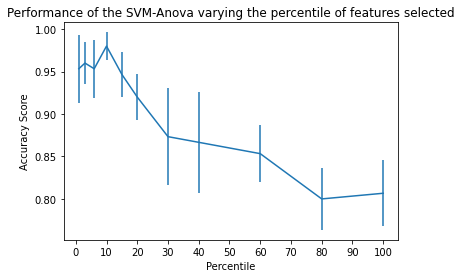

In [ ]:
import numpy as np
from sklearn.datasets import load_iris

X, y = load_iris(return_X_y=True)

rng = np.random.RandomState(0)
X = np.hstack((X, 2 * rng.random((X.shape[0], 36))))
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf = Pipeline(
    [
        ("anova", SelectPercentile(chi2)),
        ("scaler", StandardScaler()),
        ("svc", SVC(gamma="auto")),
    ]
)
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    this_scores = cross_val_score(clf, X, y)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title("Performance of the SVM-Anova varying the percentile of features selected")
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel("Percentile")
plt.ylabel("Accuracy Score")
plt.axis("tight")
plt.show()

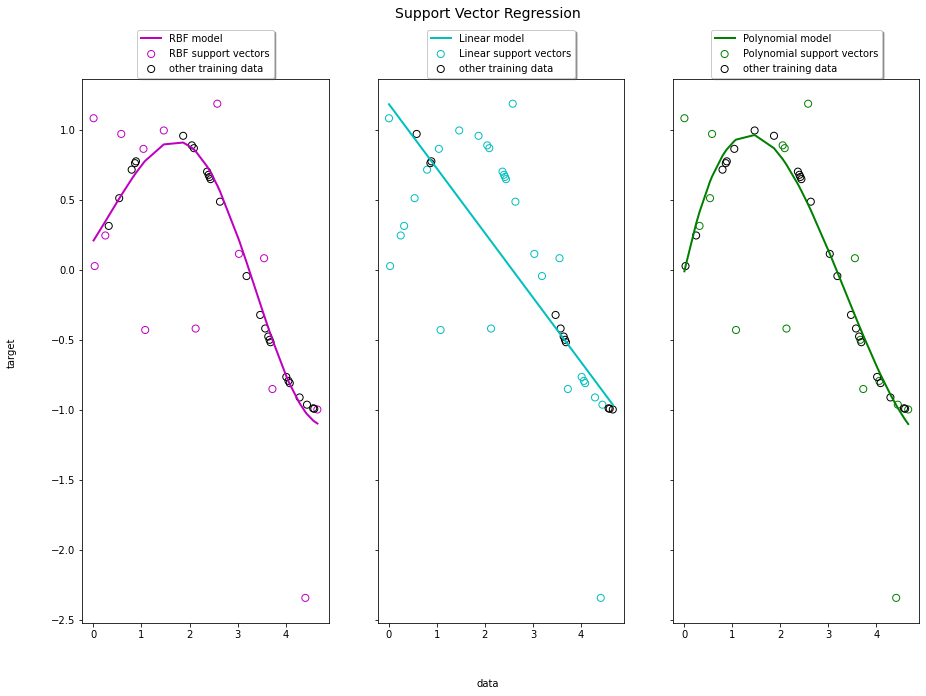

In [ ]:
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt

X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()

y[::5] += 3 * (0.5 - np.random.rand(8))

svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr_lin = SVR(kernel="linear", C=100, gamma="auto")
svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)

lw = 2

svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ["RBF", "Linear", "Polynomial"]
model_color = ["m", "c", "g"]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10), sharey=True)
for ix, svr in enumerate(svrs):
    axes[ix].plot(
        X,
        svr.fit(X, y).predict(X),
        color=model_color[ix],
        lw=lw,
        label="{} model".format(kernel_label[ix]),
    )
    axes[ix].scatter(
        X[svr.support_],
        y[svr.support_],
        facecolor="none",
        edgecolor=model_color[ix],
        s=50,
        label="{} support vectors".format(kernel_label[ix]),
    )
    axes[ix].scatter(
        X[np.setdiff1d(np.arange(len(X)), svr.support_)],
        y[np.setdiff1d(np.arange(len(X)), svr.support_)],
        facecolor="none",
        edgecolor="k",
        s=50,
        label="other training data",
    )
    axes[ix].legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.1),
        ncol=1,
        fancybox=True,
        shadow=True,
    )

fig.text(0.5, 0.04, "data", ha="center", va="center")
fig.text(0.06, 0.5, "target", ha="center", va="center", rotation="vertical")
fig.suptitle("Support Vector Regression", fontsize=14)
plt.show()

________________________________________________________________________________
Modeling distribution of species 'bradypus variegatus'
 - fit OneClassSVM ... done.
 - plot coastlines from coverage
 - predict species distribution

 Area under the ROC curve : 0.868443
________________________________________________________________________________
Modeling distribution of species 'microryzomys minutus'
 - fit OneClassSVM ... done.
 - plot coastlines from coverage
 - predict species distribution

 Area under the ROC curve : 0.993919

time elapsed: 32.69s


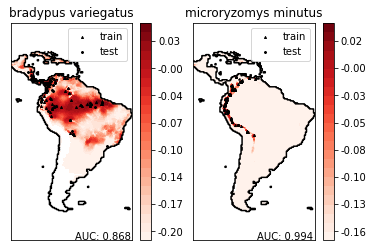

In [ ]:
from time import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import Bunch
from sklearn.datasets import fetch_species_distributions
from sklearn import svm, metrics

try:
    from mpl_toolkits.basemap import Basemap

    basemap = True
except ImportError:
    basemap = False


def construct_grids(batch):
    """Construct the map grid from the batch object

    Parameters
    ----------
    batch : Batch object
        The object returned by :func:`fetch_species_distributions`

    Returns
    -------
    (xgrid, ygrid) : 1-D arrays
        The grid corresponding to the values in batch.coverages
    """

    xmin = batch.x_left_lower_corner + batch.grid_size
    xmax = xmin + (batch.Nx * batch.grid_size)
    ymin = batch.y_left_lower_corner + batch.grid_size
    ymax = ymin + (batch.Ny * batch.grid_size)

    xgrid = np.arange(xmin, xmax, batch.grid_size)
    ygrid = np.arange(ymin, ymax, batch.grid_size)

    return (xgrid, ygrid)


def create_species_bunch(species_name, train, test, coverages, xgrid, ygrid):
    """Create a bunch with information about a particular organism

    This will use the test/train record arrays to extract the
    data specific to the given species name.
    """
    bunch = Bunch(name=" ".join(species_name.split("_")[:2]))
    species_name = species_name.encode("ascii")
    points = dict(test=test, train=train)

    for label, pts in points.items():
        pts = pts[pts["species"] == species_name]
        bunch["pts_%s" % label] = pts

        ix = np.searchsorted(xgrid, pts["dd long"])
        iy = np.searchsorted(ygrid, pts["dd lat"])
        bunch["cov_%s" % label] = coverages[:, -iy, ix].T

    return bunch


def plot_species_distribution(
    species=("bradypus_variegatus_0", "microryzomys_minutus_0")
):
    """
    Plot the species distribution.
    """
    if len(species) > 2:
        print(
            "Note: when more than two species are provided,"
            " only the first two will be used"
        )

    t0 = time()

    data = fetch_species_distributions()

    xgrid, ygrid = construct_grids(data)

    X, Y = np.meshgrid(xgrid, ygrid[::-1])

    BV_bunch = create_species_bunch(
        species[0], data.train, data.test, data.coverages, xgrid, ygrid
    )
    MM_bunch = create_species_bunch(
        species[1], data.train, data.test, data.coverages, xgrid, ygrid
    )

    np.random.seed(13)
    background_points = np.c_[
        np.random.randint(low=0, high=data.Ny, size=10000),
        np.random.randint(low=0, high=data.Nx, size=10000),
    ].T

    land_reference = data.coverages[6]

    for i, species in enumerate([BV_bunch, MM_bunch]):
        print("_" * 80)
        print("Modeling distribution of species '%s'" % species.name)

        mean = species.cov_train.mean(axis=0)
        std = species.cov_train.std(axis=0)
        train_cover_std = (species.cov_train - mean) / std

        print(" - fit OneClassSVM ... ", end="")
        clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.5)
        clf.fit(train_cover_std)
        print("done.")

        plt.subplot(1, 2, i + 1)
        if basemap:
            print(" - plot coastlines using basemap")
            m = Basemap(
                projection="cyl",
                llcrnrlat=Y.min(),
                urcrnrlat=Y.max(),
                llcrnrlon=X.min(),
                urcrnrlon=X.max(),
                resolution="c",
            )
            m.drawcoastlines()
            m.drawcountries()
        else:
            print(" - plot coastlines from coverage")
            plt.contour(
                X, Y, land_reference, levels=[-9998], colors="k", linestyles="solid"
            )
            plt.xticks([])
            plt.yticks([])

        print(" - predict species distribution")

        Z = np.ones((data.Ny, data.Nx), dtype=np.float64)

        idx = np.where(land_reference > -9999)
        coverages_land = data.coverages[:, idx[0], idx[1]].T

        pred = clf.decision_function((coverages_land - mean) / std)
        Z *= pred.min()
        Z[idx[0], idx[1]] = pred

        levels = np.linspace(Z.min(), Z.max(), 25)
        Z[land_reference == -9999] = -9999

        plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)
        plt.colorbar(format="%.2f")

        plt.scatter(
            species.pts_train["dd long"],
            species.pts_train["dd lat"],
            s=2**2,
            c="black",
            marker="^",
            label="train",
        )
        plt.scatter(
            species.pts_test["dd long"],
            species.pts_test["dd lat"],
            s=2**2,
            c="black",
            marker="x",
            label="test",
        )
        plt.legend()
        plt.title(species.name)
        plt.axis("equal")

        pred_background = Z[background_points[0], background_points[1]]
        pred_test = clf.decision_function((species.cov_test - mean) / std)
        scores = np.r_[pred_test, pred_background]
        y = np.r_[np.ones(pred_test.shape), np.zeros(pred_background.shape)]
        fpr, tpr, thresholds = metrics.roc_curve(y, scores)
        roc_auc = metrics.auc(fpr, tpr)
        plt.text(-35, -70, "AUC: %.3f" % roc_auc, ha="right")
        print("\n Area under the ROC curve : %f" % roc_auc)

    print("\ntime elapsed: %.2fs" % (time() - t0))


plot_species_distribution()
plt.show()

The best parameters are {'C': 1.0, 'gamma': 0.1} with a score of 0.97


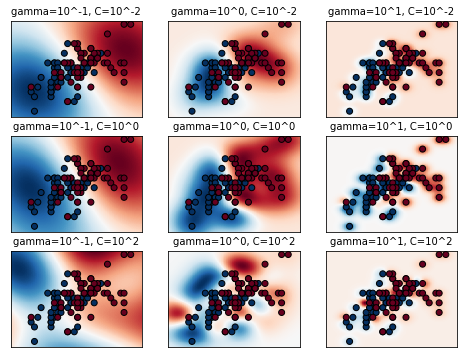

In [ ]:
import numpy as np
from matplotlib.colors import Normalize


class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target

X_2d = X[:, :2]
X_2d = X_2d[y > 0]
y_2d = y[y > 0]
y_2d -= 1

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_2d = scaler.fit_transform(X_2d)


from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)


C_2d_range = [1e-2, 1, 1e2]
gamma_2d_range = [1e-1, 1, 1e1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_2d, y_2d)
        classifiers.append((C, gamma, clf))

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
for k, (C, gamma, clf) in enumerate(classifiers):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)), size="medium")

    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, cmap=plt.cm.RdBu_r, edgecolors="k")
    plt.xticks(())
    plt.yticks(())
    plt.axis("tight")

scores = grid.cv_results_["mean_test_score"].reshape(len(C_range), len(gamma_range))